In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn as nn
from PIL import Image 
from torchvision.utils import save_image
import os

%matplotlib inline
plt.style.use("ggplot")


class CFG:
    batch_size = 100
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3 ## number chanels
    ngf = 64 #Size of feature maps in generator
    nz = 100 #latent random input vector
    ndf = 64 #Size of feature maps in discriminator
    lr = 0.0002
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    sample_dir = "./images/"

if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)
dataset = torchvision.datasets.CIFAR10(root=CFG.dataroot, download=CFG.download,
                               transform=transforms.Compose([
                                  transforms.Resize([CFG.image_size, CFG.image_size]),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))



Extracting data/cifar-10-python.tar.gz to data


In [2]:
dataset[0][0].shape

torch.Size([3, 64, 64])

Label:  6


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.8745098 , -0.8112418 , -0.74797386, -0.68470585, -0.6214379 ,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986], dtype=float32),
 <a list of 300 BarContainer objects>)

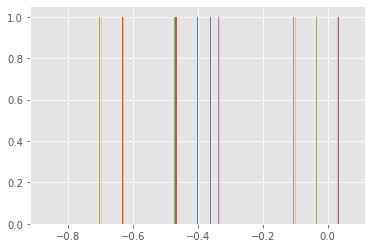

In [3]:
img, label = dataset[0]
print('Label: ', label)
plt.hist(img[:,5:15,5:15].flatten(), bins=15)

In [4]:
# unnormalization image from range (-1)-0 to range 0-1 to display it
def unnomalization(img):
    return (img+1)/2

In [5]:
# Create the dataloader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=CFG.batch_size, shuffle=True)

In [6]:
len(data_loader)

500

In [7]:
CFG.device

'cpu'


## GAN 
состоит из двух глубоких сетей, генератора и дискриминатора. генератор создает изображения, прежде чем научиться его обучать. Поскольку дискриминатор представляет собой модель бинарной классификации, мы можем использовать функцию потери бинарной кросс-энтропии для количественной оценки того, насколько хорошо он может различать реальные и сгенерированные изображения.

In [26]:
import torch.nn as nn
import torch.nn.functional as F
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        #ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu 
        #ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        if x.is_cuda:
            output = nn.parallel.data_parallel(self.main, x, range(torch.cuda.device_count()))
        else:
            output = self.main(x)
        return output


class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
    #conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        if x.is_cuda:
            output = nn.parallel.data_parallel(self.main, x, range(torch.cuda.device_count()))
        else:
            output = self.main(x)

        return output.view(-1, 1)


In [27]:
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)
# create new Discriminator model
D = Discriminator(CFG.nc, CFG.ngf).to(CFG.device)

In [28]:

# show the output of model 
y = G(torch.randn(128, CFG.nz, 1, 1).to(CFG.device))
y = y.to(CFG.device)
y.shape

torch.Size([128, 3, 64, 64])

In [29]:
x = D(y)
x.shape

torch.Size([128, 1])

In [30]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
G_optimizer = torch.optim.Adam(G.parameters(), lr = CFG.lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = CFG.lr)

In [31]:

def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()

def train_discriminator(images):
  
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(CFG.batch_size, 1).to(CFG.device)
    fake_labels = torch.zeros(CFG.batch_size, 1).to(CFG.device)
        
    
    outputs = D(images)
    # Loss for real images
    real_loss = criterion(outputs, real_labels)
    
    real_score = outputs

    # Loss for fake images
    z = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = G(z)
    outputs = D(fake_images)
    fake_loss = criterion(outputs, fake_labels)

    fake_score = outputs

    # Sum losses
    d_loss = real_loss + fake_loss

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    D_optimizer.step()
    
    return d_loss, real_score, fake_score

In [32]:
def train_generator():
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (CFG.batch_size, CFG.nz, 1, 1))).to(CFG.device)
    fake_images = G(z)
    fake_outputs = D(fake_images)
    labels = torch.ones(CFG.batch_size, 1).to(CFG.device)
    # calculate the generator loss
    g_loss = criterion(fake_outputs, labels)

    
    # Reset gradients
    reset_grad()
    
    # Backprop and optimize
    g_loss.backward()
    G_optimizer.step()

    return g_loss, fake_images

## Start the training proccess

In [55]:
def save_fake_images(index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz , 1 , 1).to(CFG.device)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(unnomalization(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [34]:

%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(CFG.device)
D.to(CFG.device)
for epoch in range(CFG.num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.to(CFG.device)
        # images = images.reshape(CFG.batch_size, -1).to(CFG.device)
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)  

        # Train the generator
        g_loss, fake_image = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, CFG.num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/500], d_loss: 0.1470, g_loss: 9.8034, D(x): 0.98, D(G(z)): 0.00
Epoch [0/300], Step [400/500], d_loss: 0.0079, g_loss: 11.4366, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [1/300], Step [200/500], d_loss: 0.0204, g_loss: 8.1195, D(x): 0.99, D(G(z)): 0.01
Epoch [1/300], Step [400/500], d_loss: 0.0063, g_loss: 9.3033, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/500], d_loss: 0.0081, g_loss: 8.8759, D(x): 1.00, D(G(z)): 0.00
Epoch [2/300], Step [400/500], d_loss: 0.0063, g_loss: 8.5301, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [3/300], Step [200/500], d_loss: 0.1071, g_loss: 14.4378, D(x): 0.93, D(G(z)): 0.00
Epoch [3/300], Step [400/500], d_loss: 0.0531, g_loss: 6.2231, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0004.png
Epoch [4/300], Step [200/500], d_loss: 0.1097, g_loss: 8.4639, D(x): 0.94, D(G(z)): 0.00
Epoch [4/300], Step [400/500], d_loss: 0.0147, g_loss: 11.4631, D(x): 0.99, D(G(z)): 

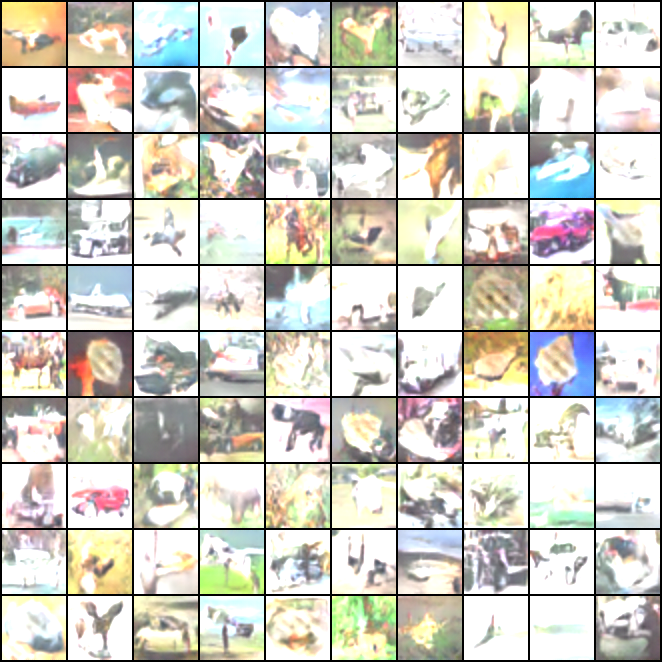

In [60]:
Image.open(os.path.join(CFG.sample_dir, 'fake_images-0275.png'))

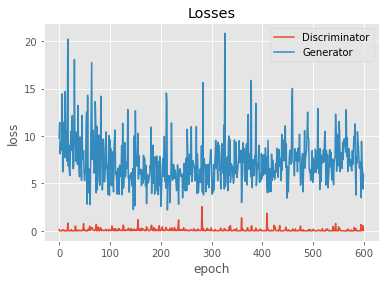

In [43]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

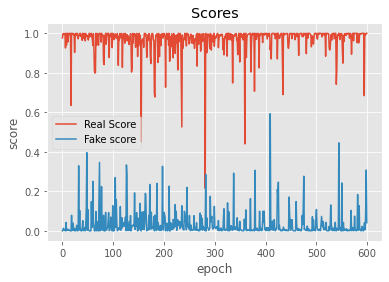

In [44]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [46]:
if not os.path.exists("./checkpoint/"):
    os.makedirs("./checkpoint/")
torch.save(
    G.state_dict(),
    "checkpoint/generator_model.pth")
torch.save(
    D.state_dict(),
    "checkpoint/discrimator_model.pth")